# Objective

We are using the UCI Heart Disease Data from Kaggle in the file data/raw/heart.csv

We will try to predict the indication of heart disease in the target variable.

It has 14 columns, 13 potential feature variables and 1 boolean target variable, so we are doing a classification problem.
In this notebook we will do data wrangling to characterize the data and verify which variables are good to use.

# 1. Load and characterize the data from heart.csv

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from library.sb_utils import save_file

In [3]:
heart_data = pd.read_csv("../data/raw/heart.csv")
heart_data.info()
heart_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


### Data availability and types

All 14 columns have data in all 303 rows.  No missing data.
Only 1 floating point column - oldpeak.  The rest are all integers.  

### Column Descriptions

Some of the data columns have esoteric names and descriptions.  Let's go over each variable and what it means.

- age (years)
- sex (F=0, M=1)
- cp (Chest Pain Type) (Actual values: 0-3) Definition on the UCI site: 1=Typical Angina, 2=Atypical Angina, 3=Non-Anginal Pain, 4= Asymptomatic.   
This raises the question "Is it translated down to the 0-based indexes, or has 4 been converted to 0, like you'd expect for no pain?"  http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/  We will look at the data in context to try to find the answer.
- trestbps (Resting blood pressure in mm Hg at admission), doesn't say whether it's diastolic or systolic, but the range is 94 to 200, so it has to be the top/bigger number (systolic, the pressure when the heart is exerting maximum force). https://pubmed.ncbi.nlm.nih.gov/12698068/
https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained 
- chol (Serum Cholesterol in mg/dl) https://www.healthline.com/health/serum-cholesterol#results
- fbs (Fasting Blood Sugar > 120 mg/dl or not) They just captured this boolean rather than the actual number.  The CDC says that 100-125 is an indication of pre-diabetes and above 125 shows diabetes.  https://www.cdc.gov/diabetes/basics/getting-tested.html
- restecg (Resting Electrocardiographic results)  (Actual values: 0-2) not explained  https://www.nhs.uk/conditions/electrocardiogram/
This time UCI shows the 0-based index values.  0 = Normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach (Maximum Heart Rate Achieved) Think this is during a tread-mill exercise test, but it doesn't say.  https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm
- exang (Exercise induced angina (angina heart pain during tread-mill test)) (No=0, Yes=1)
https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-and-treatments

- oldpeak (ST depression induced by exercise relative to rest)
What the heck is ST?   It's a characteristic segment of a person's sinus rhythm as seen on an ECG.  
According to the Interpretation section of https://en.wikipedia.org/wiki/ST_segment, it can indicate several different things regarding the heart: 
1. The normal ST segment has a slight upward concavity.
2. Flat, downsloping, or depressed ST segments may indicate coronary ischemia.
3. ST elevation may indicate transmural myocardial infarction. An elevation of >1mm and longer than 80 milliseconds following the J-point. This measure has a false positive rate of 15-20% (which is slightly higher in women than men) and a false negative rate of 20-30%.
4. ST depression may be associated with subendocardial myocardial infarction, hypokalemia, or digitalis toxicity.

- slope (Peak Exercise ST segment slope) (Actual values: 0-2) https://pubmed.ncbi.nlm.nih.gov/3739881/   1=Upsloping, 2=Flat, 3=Downsloping.  As with cp, do we slide them down 1 from 1-3 to get the 0-2?  http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/
- ca    (# of major vessels colored by fluoroscopy) (Actual values: 0-3) A vessel that shows up with the dye color has good flow.
- thal (not explained) (0-7) (Kaggle says 3=normal, 6=fixed defect, 7=reversible defect) but range of actual data is only 0-3.  Not defined what it is. Some modelers of this data claim this is a blood disorder called beta thalassemia, and at least one other calls it the thalium stress test result.  The blood disorder does not match well to this and there are other indications of a stress test involved in this data (oldpeak, slope and thalach).  I will ask in the Kaggle discussion and otherwise just take it at face value.  thal is not explained on the UCI source site, but other "thal" variables have to do with an exercise stress test, so verify the context matches that, NOT the thalassemia.

-- target (Patient is diagnosed with heart disease) (No=0, Yes=1)

# 2. "Corrected" Dataset

A Kaggle user named Usama bin Shakeel provides an alternative CSV file purporting to correct the dataset with target values ranging from 0 to 4, as mentioned in the discussion context.  However, one commenter says the other data is corrupted.  Bin Shakeel does not say where he got the corrected data.  Let's compare against the original dataset.

### Load the alternative "corrected" dataset

In [4]:
alternative_data = pd.read_csv("../data/raw/Heart Corrected.csv", na_values='?')
alternative_data.info()
alternative_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
7,57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
9,53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


## Compare the datasets

I had to eliminate an index column in the Google Sheets (CSV) file and change the column labels back to the original for DataFrame comparison.

The order of the rows is different, so in Google Sheets I re-ordered them both with age, then chol, then thalach, as those last two columns seem to have the most distinctive values.

As advertised, target now contains values over the full range from 0 to 3, not just 0 and 1, which would make for a 4-value classification problem.

Other columns changed, too.  ca and thal both have some "?" entries, rendering them objects in the DF.  I used na_values to make them NaN.  Pandas made them float values, despite them being integers in Google Sheets.  ca has 4 missing values and thal has 2.  

thal has values over the full commented range, 0 to 7, which makes more sense.

### Load both re-ordered datasets

In [5]:
heart_sorted = pd.read_csv("../data/raw/heart - sorted.csv")
heart_sorted.info()

alt_sorted = pd.read_csv("../data/raw/Heart Corrected - sorted.csv", na_values='?')
alt_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64

In [6]:
heart_sorted.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,77,1,0,125,304,0,0,162,1,0.0,2,3,2,0
1,76,0,2,140,197,0,2,116,0,1.1,1,0,2,1
2,74,0,1,120,269,0,0,121,1,0.2,2,1,2,1
3,71,0,1,160,302,0,1,162,0,0.4,2,2,2,1
4,71,0,2,110,265,1,0,130,0,0.0,2,1,2,1


In [7]:
alt_sorted.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,77,1,4,125,304,0,2,162,1,0.0,1,3.0,3.0,4
1,76,0,3,140,197,0,1,116,0,1.1,2,0.0,3.0,0
2,74,0,2,120,269,0,2,121,1,0.2,1,1.0,3.0,0
3,71,0,2,160,302,0,0,162,0,0.4,1,2.0,3.0,0
4,71,0,3,110,265,1,2,130,0,0.0,1,1.0,3.0,0


In [8]:
heart_sorted.compare(alt_sorted)

age        sex         cp       trestbps       chol        ... oldpeak  \
    self other self other self other     self other self other  ...    self   
0    NaN   NaN  NaN   NaN  0.0   4.0      NaN   NaN  NaN   NaN  ...     NaN   
1    NaN   NaN  NaN   NaN  2.0   3.0      NaN   NaN  NaN   NaN  ...     NaN   
2    NaN   NaN  NaN   NaN  1.0   2.0      NaN   NaN  NaN   NaN  ...     NaN   
3    NaN   NaN  NaN   NaN  1.0   2.0      NaN   NaN  NaN   NaN  ...     NaN   
4    NaN   NaN  NaN   NaN  2.0   3.0      NaN   NaN  NaN   NaN  ...     NaN   
..   ...   ...  ...   ...  ...   ...      ...   ...  ...   ...  ...     ...   
298  NaN   NaN  NaN   NaN  1.0   2.0      NaN   NaN  NaN   NaN  ...     NaN   
299  NaN   NaN  NaN   NaN  0.0   4.0      NaN   NaN  NaN   NaN  ...     NaN   
300  NaN   NaN  NaN   NaN  1.0   2.0      NaN   NaN  NaN   NaN  ...     NaN   
301  NaN   NaN  NaN   NaN  3.0   1.0      NaN   NaN  NaN   NaN  ...     NaN   
302  NaN   NaN  NaN   NaN  1.0   2.0      NaN   NaN  NaN   NaN  ...     NaN   

          slope         ca       thal       target        
    other  self other self other self other   self other  
0     NaN   2.0   1.0  NaN   NaN  2.0   3.0    0.0   4.0  
1     NaN   1.0   2.0  NaN   NaN  2.0   3.0    1.0   0.0  
2     NaN   2.0   1.0  NaN   NaN  2.0   3.0    1.0   0.0  
3     NaN   2.0   1.0  NaN   NaN  2.0   3.0    1.0   0.0  
4     NaN   2.0   1.0  NaN   NaN  2.0   3.0    1.0   0.0  
..    ...   ...   ...  ...   ...  ...   ...    ...   ...  
298   NaN   2.0   1.0  NaN   NaN  2.0   3.0    1.0   0.0  
299   NaN   2.0   1.0  NaN   NaN  2.0   3.0    1.0   0.0  
300   NaN   2.0   1.0  NaN   NaN  2.0   3.0    1.0   0.0  
301   NaN   2.0   1.0  NaN   NaN  2.0   3.0    1.0   0.0  
302   NaN   2.0   1.0  NaN   NaN  2.0   3.0    1.0   0.0  

[303 rows x 28 columns]

## Analysis of differences

The NaNs are entries that matched between heart_sorted and alt_sorted.  Any rows that were identical would not have shown up in this list, so all 303 rows have some differences.  Judging by just the first and last 5 rows Chest Pain (cp) is different with more variation in the alternative dataset.  Slope is different and perhaps more likely to be 1.  thal and target are also different.

The alternative dataset looks to provide a more interesting prediction problem to solve, but where did it come from and is it accurate?

Will look to see if Mr. Bin Shakeem provides any answers.

## Information Digging at UC - Irvine

I could not find any corroborating evidence on Kaggle, so I did some digging into the UC Irvine ML Data Repository at http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

This study was done in 1988 and analyzed by many papers over the years, BTW.  There were 76 attributes considered in the study, but only 14 attributes were reported.  This dataset is from the Cleveland Clinic.  There were 3 other datasets from Long Beach VA Hospital, Hungary, and Switzerland.

Found these improved feature descriptions:
cp: chest pain type  1 = Typical Angina, 2 = Atypical Angina, 3 = Non-Anginal Pain, 4 = Asymptomatic.  But do we convert to 4 to 0, or slide the 1-based index down to the 0-based index (1->0, 2->1, 3->2, 4->3)?

Applied this and other explanations in the list of Column Descriptions above.

This is the clincher on which dataset to use.  The UCI archive states that column 58 of the full set is column 14, the predicted attribute, of the reported set and it has only 2 values.

58 num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        
I will use the original dataset.


# 3. Distribution of the variables

There are no missing values in the original dataset, as we saw above, so let's look at the distribution of each variable.


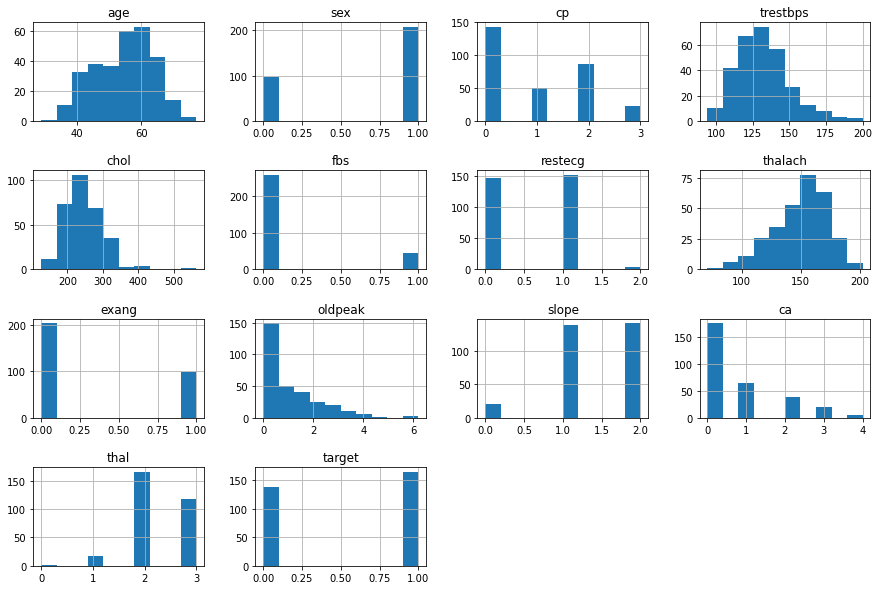

In [9]:
heart_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

A lot of these variables are ordinal or categorical with only 2 to 5 values.  There is no information from the source on whether the subjects suspected heart disease, so we don't have any real expectations on what we see here.

Let's improve the names to what's in the parentheses on the right.

#### Age (Age)
Mostly in the 35 to 70 age group with a roughly normal or lognormal shape with a peak at 60 and more to the left of the peak than the right.

#### Sex (Sex)
Twice as many men as women.  The total of 303 subjects is considerably under 1000, but big enough to be interesting. Heart disease is more prevalent in men and back in the 1980s when this data was collected, cardiac care infamously focused a lot more attention on male patients.

#### (cp) Chest Pain (ChestPain)
If we assume that category 4, Asymptomatic, is mapped to value 0 (as an ordinal variable should be), then most of the subjects are not complaining of frequent pain and atypical angina is the most common pain reported.  Otherwise if category 1, Typical Angina, has been mapped to 0, most of the subjects are complaining of typical angina pain, and very few do not have chest pain.

#### (trestbps) Resting Blood Pressure (SystolicBP)
I've learned something here https://pubmed.ncbi.nlm.nih.gov/12698068/.  The better predictor of heart disease is not the bottom (diastolic or rest phase) number as I've always heard, but the top number (systolic), when the heart is pushing its hardest.  That's why we only have 1 number and it's between 90 and 200 with a normal or lognormal shape and a larger tail to the right.

#### (chol) Cholestorol (Chol)
No LDL or HDL measurements.  They probably were not as common in 1988 as they are now.  Normal distribution around 225 with a tail to the right.

#### (fbs) Fasting Blood Glucose (Glucose)
They did not record the number, just a boolean, whether it's over 120.  Today's standards say normal is below 100, pre-diabetes is 100 to 125 and diabetes is 126 or above.  Looks like about 1/6th or 17% of the participants have diabetes.

#### (restecg) Resting Electrocardiogram (RestECG)
This is an ordinal with 3 values.  Looks like just less than half have normal ECGs. A slightly higher number have ST abnormalities in their ECG and a few have left ventricular hypotrophy.

#### (thalach) Maximum Heart Rate Achieved on Stress Test (STMaxRate)
This numeric variable has a lognormal distribution with a peak around 165.

#### (exang) Exercise-Induced Angina Pain (STPain)
One-third reported angina pain from the stress test.  Two-thirds did not.

#### (oldpeak) ST depression induced by exercise relative to rest  (STWave)
This is an odd bird.  The description lists 4 categories for this variable.  They don't even look like they are ordered.  Yet the data are floats with active values in the tenths place and the range goes up to 6.  Not sure what this means, but I'll analyze the data as reported.

#### (slope) Peak Exercise ST Segment Slope (STSlope)
Three arguably ordinal values.  Close to half have a downward slope, a little less are flat and less than 10% have upward slope.

#### (ca) Number of Major Vessels Colored by Fluoroscopy (NumColor)
This is an integer variable, not categorical, showing how many cardiac vessels show a strong color under fluoroscopy.  Despite the description stating there are 4 integer values, from 0 to 3, the data show a range of 0 to 4.  About 60% show zero vessels colored.  20% show 1, 15% show 2, less than 10% 3 and a few cases show 4 vessels colored.

#### (thal) Thalium Stress Test  (Normal, Fixed Defect, or Reversible Defect) (Defects)
Another odd bird, see the discussion above in Column Descriptions.  The Kaggle description stipulates 3 values (3, 6, 7) and the data show 4 values (0, 1, 2, 3).  Very few zero values, perhaps it is unmeasured or unknown.

#### (target)  Angiographic Disease Status (AngioTgt)
A boolean representing 0. Less than 50% diameter narrowing or 1. More than 50% diameter narrowing, as measured by angiogram.

In [10]:
rename = {'age':'Age', 'sex':'Sex', 'cp':'ChestPain', 'trestbps':'SystolicBP','chol':'Chol', 'fbs':'Glucose', 'restecg':'RestECG',\
         'thalach':'STMaxRate', 'exang':'STPain', 'oldpeak':'STWave', 'slope':'STSlope', 'ca':'NumColor', 'thal':'Defects', 'target':'AngioTgt'}
heart_data.rename(inplace=True, columns=rename)
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         303 non-null    int64  
 1   Sex         303 non-null    int64  
 2   ChestPain   303 non-null    int64  
 3   SystolicBP  303 non-null    int64  
 4   Chol        303 non-null    int64  
 5   Glucose     303 non-null    int64  
 6   RestECG     303 non-null    int64  
 7   STMaxRate   303 non-null    int64  
 8   STPain      303 non-null    int64  
 9   STWave      303 non-null    float64
 10  STSlope     303 non-null    int64  
 11  NumColor    303 non-null    int64  
 12  Defects     303 non-null    int64  
 13  AngioTgt    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# 4. Correct the ordering of ordinal variables

Some of the categorical variables had actual values which differ from the values advertised in Kaggle or UCI.  Let's examine those to see if we can identify whether the values are ordered according to a higher or lower risk of the target (coronary artery blockage as measured by angiography).  

If they are disordered and there is an observable order, we will correct the order so they are true ordinal variables.

## Chest Pain (originally cp)
UCI definition:  1. Typical Angina  2. Atypical Angina  3. Non-Anginal Pain  4. Asymptomatic

Actual values:   0, 1, 2, 3

Question to answer:  Is 0 associated with a lower risk of heart disease, and 1-3 with increasing risk?


[(0, 27.3), (1, 82.0), (2, 79.3), (3, 69.6)]


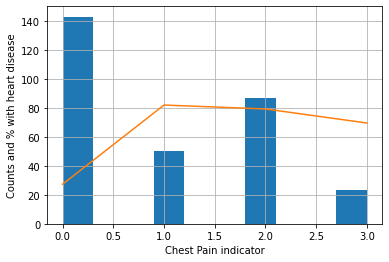

In [11]:
## Repeat the histogram of ChestPain and print the percentage of subjects with positive heart disease in each category.
heart_data.ChestPain.hist()
pctgs = [(i, 100* round(heart_data[heart_data.ChestPain == i]['AngioTgt'].mean(),3)) for i in np.sort(heart_data.ChestPain.unique())]
print(pctgs)
lst1, lst2 = zip(*pctgs)
plt.ylabel('Counts and % with heart disease')
plt.xlabel('Chest Pain indicator')
plt.plot(lst1, lst2)

So, now we see!  Only 27% of subjects coded with 0 have heart disease, while 1, 2, and 3 are in decreasing order.  For correlation to make sense, we need it to be ordered.  Apparently category 1, Typical Angina, is the worst as 82% of subjects complaining of #1 have heart disease and category 3, Non-Anginal Pain, is the mildest, as 70% of subjects with it have heart disease.  We'll move 0 to UCI's definition of 4 Asymptomatic, to make a monotonically decreasing ordering in ChestPain.

[(1, 82.0), (2, 79.3), (3, 69.6), (4, 27.3)]


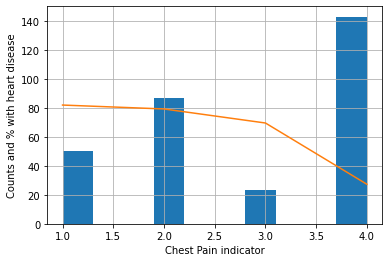

In [12]:
heart_data.ChestPain.replace(0, 4, inplace=True)
heart_data.ChestPain.hist()
pctgs = [(i, 100 * round(heart_data[heart_data.ChestPain == i]['AngioTgt'].mean(),3)) for i in np.sort(heart_data.ChestPain.unique())]
print(pctgs)
lst1, lst2 = zip(*pctgs)
plt.ylabel('Counts and % with heart disease')
plt.xlabel('Chest Pain indicator')
plt.plot(lst1, lst2)

## STWave (originally oldpeak)

Expected 4 categories.  Instead we received floats rounded to tenths ranging up to 6.  Let's look at the values and their relationship to the target.

[(0.0, 74.7), (0.1, 57.099999999999994), (0.2, 75.0), (0.3, 66.7), (0.4, 88.9), (0.5, 80.0), (0.6, 71.39999999999999), (0.7, 100.0), (0.8, 53.800000000000004), (0.9, 33.300000000000004), (1.0, 28.599999999999998), (1.1, 100.0), (1.2, 41.199999999999996), (1.3, 100.0), (1.4, 46.2), (1.5, 80.0), (1.6, 63.6), (1.8, 30.0), (1.9, 40.0), (2.0, 22.2), (2.1, 0.0), (2.2, 0.0), (2.3, 100.0), (2.4, 33.300000000000004), (2.5, 0.0), (2.6, 16.7), (2.8, 0.0), (2.9, 0.0), (3.0, 20.0), (3.1, 0.0), (3.2, 0.0), (3.4, 0.0), (3.5, 100.0), (3.6, 0.0), (3.8, 0.0), (4.0, 0.0), (4.2, 50.0), (4.4, 0.0), (5.6, 0.0), (6.2, 0.0)]


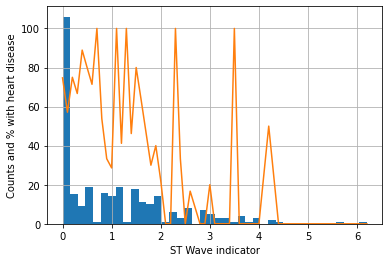

In [13]:
heart_data.STWave.hist(bins=40)
pctgs = [(i, 100 * round(heart_data[heart_data.STWave == i]['AngioTgt'].mean(), 3)) for i in np.sort(heart_data.STWave.unique())]
print(pctgs)
lst1, lst2 = zip(*pctgs)
plt.ylabel('Counts and % with heart disease')
plt.xlabel('ST Wave indicator')
plt.plot(lst1, lst2)

The blue histogram is the number of subjects with each value of STWave.  Certainly different than 4 integer categories!!

The orange line shows percentage of each category with a positive heart disease AngioTgt.  There are 3 outliers with 100%, 100%, and 50% at 2.3, 3.5, and 4.2.   The number of subjects at 3.5 and 4.2 are very small.  The overal trend is downward to the right.  

Let's round off these categories and take one more look at the trends in the percentages.

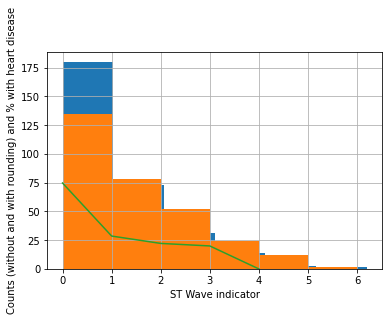

In [14]:
heart_data.STWave.hist(bins=6)
plt.hist(round(heart_data.STWave,0), bins=6)
pctgs = [(i, 100 * round(heart_data[heart_data.STWave == i]['AngioTgt'].mean(), 3)) for i in np.sort(round(heart_data.STWave,0))]
lst1, lst2 = zip(*pctgs)
plt.ylabel('Counts (without and with rounding) and % with heart disease')
plt.xlabel('ST Wave indicator')
plt.plot(lst1, lst2)

Aha!  The green line now shows a clear monotonically decreasing trend.

The orange histogram is the result of rounding before the plot.  Allowing the matplotlib to do the "binning" on its own gives the blue histogram, which shows that matplotlib takes more values between 0.5 and 1.0 for the 0th bin.  The bins to the right are slightly smaller when we didn't do the rounding ourselves.

So let's round the values of STWave to get this nice decreasing trend.

Age           int64
Sex           int64
ChestPain     int64
SystolicBP    int64
Chol          int64
Glucose       int64
RestECG       int64
STMaxRate     int64
STPain        int64
STWave        int64
STSlope       int64
NumColor      int64
Defects       int64
AngioTgt      int64
dtype: object


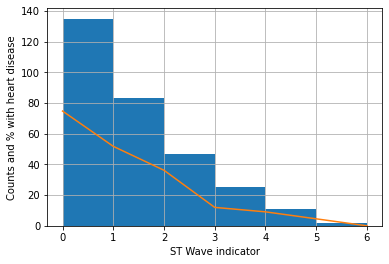

In [18]:
## Tried slicker approaches, but pandas does not seem amenable to making replacements with a function
heart_data.STWave.replace(inplace=True, to_replace={0.1:0, 0.2:0, 0.3:0, 0.4:0, 0.5:0, \
                                     0.6:1, 0.7:1, 0.8:1, 0.9:1, 1.1:1, 1.2:1, 1.3:1, 1.4:1, 1.5:1,\
                                     1.6:2, 1.7:2, 1.8:2, 1.9:2, 2.1:2, 2.2:2, 2.3:2, 2.4:2, 2.5:2,\
                                     2.6:3, 2.7:3, 2.8:3, 2.9:3, 3.1:3, 3.2:3, 3.3:3, 3.4:3, 3.5:3,\
                                     3.6:4, 3.7:4, 3.8:4, 3.9:4, 4.1:4, 4.2:4, 4.3:4, 4.4:4, 5.6:6, 6.2:6})

## Change type to int also, not just x.0
heart_data = heart_data.astype({'STWave': 'int64'})
      
print(heart_data.dtypes)

heart_data.STWave.hist(bins=6)
pctgs = [(i, 100 * round(heart_data[heart_data.STWave == i]['AngioTgt'].mean(), 3)) for i in np.sort(heart_data.STWave)]
lst1, lst2 = zip(*pctgs)
plt.ylabel('Counts and % with heart disease')
plt.xlabel('ST Wave indicator')
plt.plot(lst1, lst2)



Now the STWave variable makes sense!

## RestECG

[(0, 46.300000000000004), (1, 63.2), (2, 25.0)]


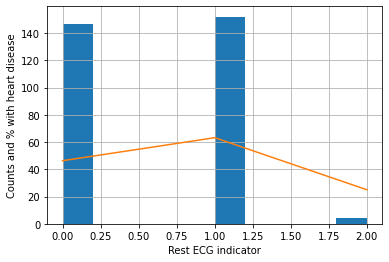

In [19]:
heart_data.RestECG.hist()
pctgs = [(i, 100* round(heart_data[heart_data.RestECG == i]['AngioTgt'].mean(),3)) for i in np.sort(heart_data.RestECG.unique())]
print(pctgs)
lst1, lst2 = zip(*pctgs)
plt.ylabel('Counts and % with heart disease')
plt.xlabel('Rest ECG indicator')
plt.plot(lst1, lst2)

The values are clearly defined and make sense.  0 is normal, 1 and 2 are two different types of medical issues.  Apparently 1 is more correlated to the AngioTgt than 2, but I'm not going to move the values around.  Especially since 0 fits between 1 and 2 to make a trend line.  So RestECG is just not going to have a clear trend relative to AngioTgt.

## NumColor (originally ca)

Just going to take a look at this confusing ordinal.

[(0, 74.3), (1, 32.300000000000004), (2, 18.4), (3, 15.0), (4, 80.0)]


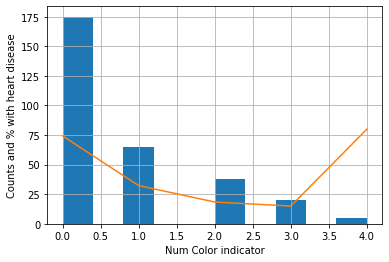

In [20]:
heart_data.NumColor.hist()
pctgs = [(i, 100* round(heart_data[heart_data.NumColor == i]['AngioTgt'].mean(),3)) for i in np.sort(heart_data.NumColor.unique())]
print(pctgs)
lst1, lst2 = zip(*pctgs)
plt.ylabel('Counts and % with heart disease')
plt.xlabel('Num Color indicator')
plt.plot(lst1, lst2)

It was unclear from the documentation whether colored cardiac blood vessels were blocked or open.  From the values 0 to 3, looks like color means the vessel is open, a good thing.  Except the small number of cases with a 4 show the worst percentage with heart disease.  We'll just leave it as an outlier and keep that in mind if it causes any issues with the fit.

## Defects (originially thal)

Contradictory definitions.  Let's dig into it.

[(0, 50.0), (1, 33.300000000000004), (2, 78.3), (3, 23.9)]


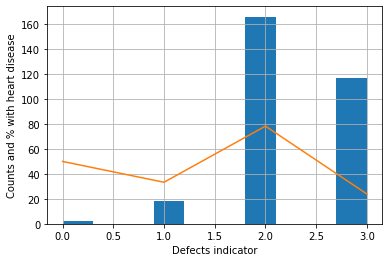

In [21]:
heart_data.Defects.hist()
pctgs = [(i, 100* round(heart_data[heart_data.Defects == i]['AngioTgt'].mean(),3)) for i in np.sort(heart_data.Defects.unique())]
print(pctgs)
lst1, lst2 = zip(*pctgs)
plt.ylabel('Counts and % with heart disease')
plt.xlabel('Defects indicator')
plt.plot(lst1, lst2)

No consistent trend in Defects.  Most of the subjects are 2s or 3s.  78% of 2s have heart disease and 24% of 3s, but 0s and 1s fall somewhere in between.  Leave it as is.

# 5. Data Selection

Further search of the UCI ML Archive and Kaggle shed no light on the discrepancies in some of the variables between the data descriptions and the range of the actual data.  

One could look for the other 3 data sets (from Long Beach VA, Hungary and Switzerland), but there is no link to them and that is beyond the scope of this project.  The dataset is 34 years old, so it seems there's really no choice but to take the original dataset as is.  

The distributions make sense, there is no missing data, and there are no real outliers.

Save the data with the new column names.

In [22]:
datapath = '../data'
save_file(heart_data, 'heart.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\heart.csv"
